# USDM & SPI - Pixel Comparison

a. stein 6.2.2022

Instead of aggregating into area fractions, this notebook aims to do a pixel resolution comparison between USDM and SPI.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [3]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 5/2/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

In [4]:
test_pixel = paired_ds['USDM'].isel(lat=40, lon=100)

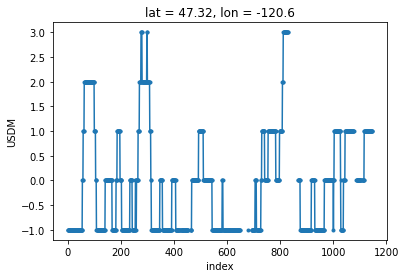

In [5]:
test_pixel.plot(marker='.')

In [6]:
test_ac = np.correlate(test_pixel, test_pixel, mode='full')
test_ac

array([-1., -2., -3., ..., -3., -2., -1.])

Helpful guide on what correlation is: https://www.youtube.com/watch?v=cuD-LXic2cE

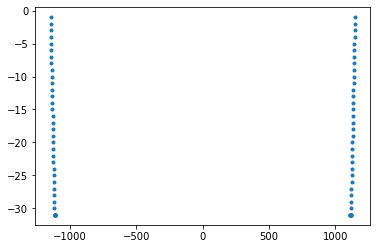

In [7]:
fig, ax = plt.subplots()

ax.plot(np.arange(-1147, 1148, 1), test_ac, marker='.', linestyle='')

So it looks like there is an issue with numpy doing calculations with nans ...

In [8]:
np.nan + 1

nan

Yeah alright then. Hm. I can try writing my own function to handle them now that I know more about correlation?

Actually that might be rather complicated ... let's just use the statistical correlation coefficient and impost a phase lag.

### $r = \frac{n(\sum{xy}) - (\sum{x})(\sum{y})}{\sqrt{[n\sum{x^2} - (\sum{x})^2][n\sum{y^2} - (\sum{y})^2]}}$

In [9]:
np.corrcoef(test_pixel, test_pixel)

array([[nan, nan],
       [nan, nan]])

Cool, the numpy function isn't helpful there

In [10]:
def nan_corrcoef(x, y):

    n = len(x)
    if n != len(y):
        raise Exception('x and y are not the same size')

    numer = n*np.sum(x*y) - (np.sum(x)*np.sum(y))
    denom = n*np.sum(x**2) - np.sum(x)**2
    denom *= n*np.sum(y**2) - np.sum(y)**2
    denom = np.sqrt(denom)

    return numer/denom

In [11]:
nan_corrcoef(test_pixel, test_pixel)

<xarray.DataArray 'USDM' ()>
array(1.)
Coordinates:
    lat      float64 47.32
    lon      float64 -120.6

Awesome. Dunno why the numpy function doesn't work but I'm just happy to have a function that does.

In [12]:
def lag_nan_corrcoef(x:xr.DataArray, y:xr.DataArray, lag:int, lag_step=1):

    n = len(x)
    if n != len(y):
        raise Exception('x and y are not the same size')
    if lag > n:
        raise Exception('lag cannot exceed size of x or y')
    
    r_array = []

    # check if empty pixel
    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        r_array = np.nan*np.arange(-1*lag, lag+1, 1)
    else:
        for lag_i in np.arange(-lag, 0, 1):
            r_array.append(nan_corrcoef(x[:lag_i], y[-1*lag_i:]).values)
        r_array.append(nan_corrcoef(x, y).values)
        for lag_i in np.arange(1, lag+1, 1):
            r_array.append(nan_corrcoef(x[lag_i:], y[:-1*lag_i]).values)

    return np.arange(-1*lag, lag+1, 1), np.hstack(r_array)

In [13]:
lag, r = lag_nan_corrcoef(test_pixel, test_pixel, lag=50)

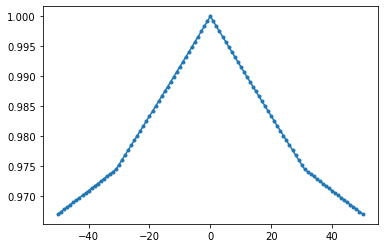

In [14]:
fig, ax = plt.subplots()

ax.plot(lag, r, marker='.')

Nice, that looks right for an autocorrelation check.

Now what if I do this between USDM and SPI?

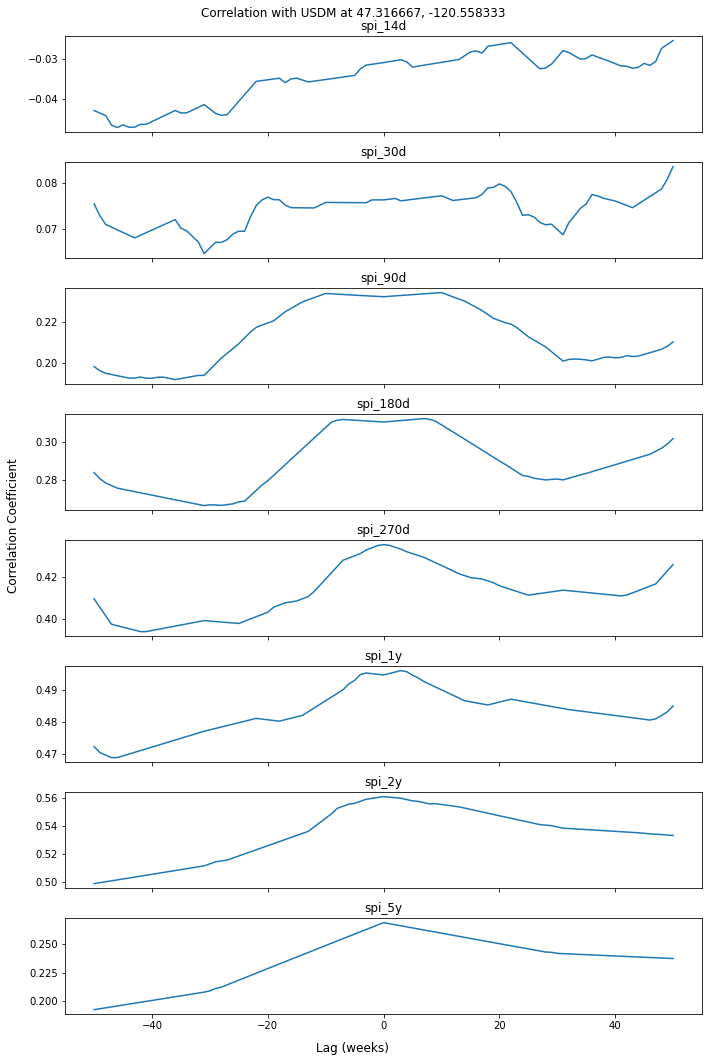

In [15]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(10,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    lag, r = lag_nan_corrcoef(paired_pixel['USDM'], paired_pixel[f'spi_{spi_int}'], lag=50)

    ax.plot(lag, r)
    ax.set_title(f'spi_{spi_int}')

fig.suptitle(f'Correlation with USDM at {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Correlation Coefficient')
fig.supxlabel('Lag (weeks)')

plt.tight_layout()

Cool. Now what if we spaghetti this?

In [16]:
paired_ds.load()

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 0
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_2y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_5y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_14d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_30d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_90d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_180d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_270d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Attributes:
    author:       a. stein 5/2/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

Need to speed this up

In [17]:
import multiprocessing as mp

In [18]:
mp.Pool?

Signature:
mp.Pool(
    processes=None,
    initializer=None,
    initargs=(),
    maxtasksperchild=None,
)
Docstring: Returns a process pool object
File:      /pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/multiprocessing/context.py
Type:      method


In [19]:
pool = mp.Pool(processes=30)

In [20]:
pool.map?

Signature: pool.map(func, iterable, chunksize=None)
Docstring:
Apply `func` to each element in `iterable`, collecting the results
in a list that is returned.
File:      /pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/multiprocessing/pool.py
Type:      method


In [21]:
def compute_r(args):
    spi_var, lat, lon, lag = args
    pixel_ds = paired_ds.sel(lat=lat, lon=lon)
    __, r_pix = lag_nan_corrcoef(pixel_ds['USDM'], pixel_ds[spi_var], lag=lag)
    #t.update()
    return r_pix

double check this works ...

In [22]:
compute_r(['spi_1y', paired_ds.lat.values[50], paired_ds.lon.values[80], 50])

array([0.57712709, 0.57495491, 0.57482495, 0.57401678, 0.57349032,
       0.57296398, 0.57243774, 0.57259046, 0.57293724, 0.57308931,
       0.57343628, 0.5737837 , 0.57413156, 0.57496023, 0.57578803,
       0.57661497, 0.57744104, 0.57826626, 0.57909062, 0.57991413,
       0.58025961, 0.58060553, 0.58095189, 0.58129869, 0.58164593,
       0.58199361, 0.58234173, 0.58269027, 0.58303925, 0.58338866,
       0.58373851, 0.58408878, 0.58443947, 0.58479059, 0.58514214,
       0.58549411, 0.5858465 , 0.58619931, 0.58655254, 0.58690618,
       0.58726024, 0.58761472, 0.58842859, 0.58924165, 0.59005389,
       0.59086532, 0.59167594, 0.59248576, 0.59329477, 0.59410298,
       0.59491039, 0.59410298, 0.59329477, 0.59248576, 0.59167594,
       0.59086532, 0.59005389, 0.58924165, 0.58842859, 0.58761472,
       0.58709744, 0.58658109, 0.58606565, 0.58560291, 0.58514037,
       0.58499811, 0.5848555 , 0.58439266, 0.58393003, 0.58378657,
       0.58364276, 0.58349859, 0.58335407, 0.58320918, 0.58306

Going to flatten this to help with performance and reshape after

In [24]:
args = []

for lat in paired_ds.lat.values:
    for lon in paired_ds.lon.values:
        args.append(('spi_1y', lat, lon, 50))

args

[('spi_1y', 48.983333333333334, -124.72499996666667, 50),
 ('spi_1y', 48.983333333333334, -124.68333330000002, 50),
 ('spi_1y', 48.983333333333334, -124.64166663333334, 50),
 ('spi_1y', 48.983333333333334, -124.59999996666667, 50),
 ('spi_1y', 48.983333333333334, -124.55833330000002, 50),
 ('spi_1y', 48.983333333333334, -124.51666663333334, 50),
 ('spi_1y', 48.983333333333334, -124.47499996666667, 50),
 ('spi_1y', 48.983333333333334, -124.43333330000002, 50),
 ('spi_1y', 48.983333333333334, -124.39166663333334, 50),
 ('spi_1y', 48.983333333333334, -124.34999996666667, 50),
 ('spi_1y', 48.983333333333334, -124.30833330000002, 50),
 ('spi_1y', 48.983333333333334, -124.26666663333334, 50),
 ('spi_1y', 48.983333333333334, -124.22499996666667, 50),
 ('spi_1y', 48.983333333333334, -124.18333330000002, 50),
 ('spi_1y', 48.983333333333334, -124.14166663333334, 50),
 ('spi_1y', 48.983333333333334, -124.09999996666667, 50),
 ('spi_1y', 48.983333333333334, -124.05833330000002, 50),
 ('spi_1y', 48

In [27]:
len(args)

15792

In [39]:
n = 188
m = 84
n*m

15792

In [74]:
results = pool.map(compute_r, tqdm(args[:n*m]))

  0%|          | 0/15792 [00:00<?, ?it/s]

In [75]:
results

[array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [76]:
results_reshaped = np.array([results[(i-1)*n:i*n] for i in np.arange(1,m+1)])

In [77]:
np.shape(results_reshaped)

(84, 188, 101)

In [78]:
results_max = np.array([[results_reshaped[i,j,:].max() for j in np.arange(n)] for i in np.arange(m)])

In [79]:
results_max

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

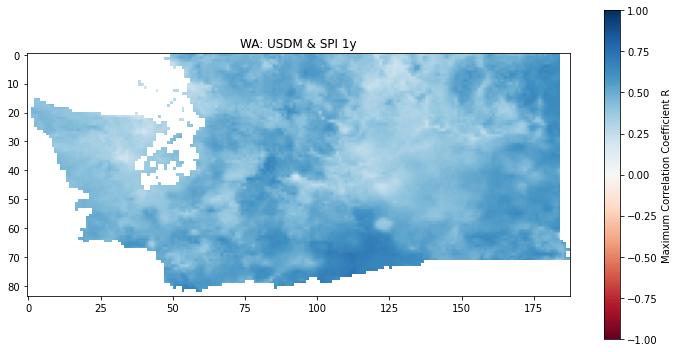

In [93]:
fig, ax = plt.subplots(figsize=(10,5))

plot_max = ax.imshow(results_max, vmin=-1, vmax=1, cmap='RdBu')

fig.colorbar(plot_max, label='Maximum Correlation Coefficient R')
ax.set_title('WA: USDM & SPI 1y')

plt.tight_layout()

In [81]:
results_max_dex = np.array([[np.argmax(results_reshaped[i,j,:]) for j in np.arange(n)] for i in np.arange(m)])
results_max_dex

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

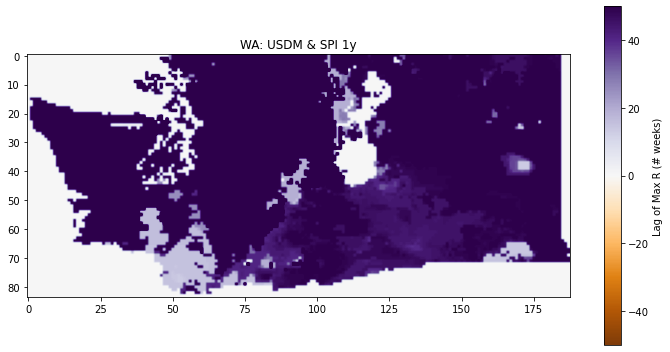

In [97]:
fig, ax = plt.subplots(figsize=(10,5))

plot_max = ax.imshow(results_max_dex, vmin=-50, vmax=50, cmap='PuOr')

fig.colorbar(plot_max, label='Lag of Max R (# weeks)')
ax.set_title('WA: USDM & SPI 1y')

plt.tight_layout()

And now what if I plot the spaghetti? 

Text(0, 0.5, 'Correlation Coefficient')

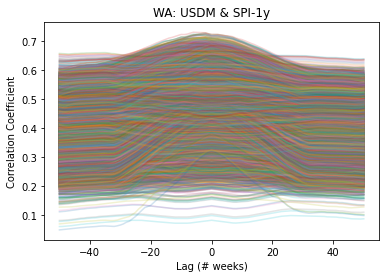

In [99]:
fig, ax = plt.subplots()

lags = np.arange(-50, 51)

for i in np.arange(m):
    for j in np.arange(n):
        ax.plot(lags, results_reshaped[i,j,:], alpha=0.2)

ax.set_title('WA: USDM & SPI-1y')
ax.set_xlabel('Lag (# weeks)')
ax.set_ylabel('Correlation Coefficient')

Well that's just a mess.

What if I color code by ... longitude?